### Evaluate CV's

In [236]:
import openai
# Core
import os
import re
import io
import logging
import pathlib
import sqlite3
from typing import TypedDict, List

# I/O and environment
from dotenv import load_dotenv, find_dotenv
from PyPDF2 import PdfReader
from IPython.display import display, Markdown, Image

# LangChain
from langchain.chains import RetrievalQA, LLMChain, StuffDocumentsChain
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Pinecone
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

# LangGraph
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

# memory = SqliteSaver.from_conn_string(":memory:")

In [237]:
# Load enviroment
load_dotenv(find_dotenv())
memory = SqliteSaver(sqlite3.connect(":memory:", check_same_thread=False))
openai_api_key = os.getenv("OPENAI_API_KEY")
pinecone_api_key = os.getenv('PINECONE')

# Set the api keys
openai.api_key =openai_api_key
client = openai.OpenAI()

MODEL_NAME = "gpt-4o-mini"  # Change to "gpt-3.5-turbo" if needed

In [238]:
# Initialize OpenAIEmbedding from Langchain
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

pc = Pinecone(api_key=pinecone_api_key)

index = pc.Index("quickstart")

# Initialize Pinecone using Langchaing and sending the embedding
pinecone_vectorstore = PineconeVectorStore(index=index, embedding=embeddings)

In [239]:
## Load the files
from langchain.document_loaders import PyPDFLoader

def load_pdf_texts_from_folder(folder_path: str):
    all_docs = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".pdf"):
            pdf_path = os.path.join(folder_path, filename)
            loader = PyPDFLoader(pdf_path)
            pages = loader.load()
            all_docs.extend(pages)
            
    return all_docs


folder_path = pathlib.Path().resolve()
docs_in_folder = load_pdf_texts_from_folder(folder_path)
print(docs_in_folder)
texts = [doc.page_content for doc in docs_in_folder]
print(texts)


[Document(metadata={'producer': 'Skia/PDF m110 Google Docs Renderer', 'creator': 'PyPDF', 'creationdate': '', 'title': 'cvFS_VE', 'source': 'D:\\Documents\\IA\\NLPII\\_Ejercicios_\\docs\\cvFS.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='IoT/Embedded Systems EngineerFABIAN  SARMIENTO\xa0\xa0+541166673518flsarmiento.v@gmail.comhttps://www.linkedin.com/in/fabian-sarmiento-976b0764/\nProfile\nProfessional in Engineering with critical thinking and high analytic capacity. I enjoy learning and facing newchallenges. I ampassionateabout theInternetofThingsandEmbeddedSystems. Myworkisorientedtoobjectivesand I like to be part of everything my team is working on .\nEmployment History\n● IoT Project Leader  -  Internet of Fields - Freb. 2022 - TodayDesign, deployment and operation  of sensor networks for Smart AgricultureMonitoring of production process of  sensors for Smart AgricultureDeployment and monitoring of weather stations● Train Electrical Engineer (TEE)—EMEPA- Sept

In [240]:

doc_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100, separators=["\n\n", "\n", ".", " "])
documents_for_evaluation = doc_splitter.split_documents(docs_in_folder)

#metadata = [{"filename": "cvFS.pdf"} for _ in range(len(docs_in_folder))]
#docs = doc_splitter.create_documents([texts], metadatas=metadata)

#print(documents_for_evaluation)

indices = [f"{'CV'}_{i+1}" for i in range(len(documents_for_evaluation))]

In [241]:
# Upload the vector embedding to pinecone
pinecone_vectorstore.add_documents(documents=documents_for_evaluation, ids=indices)

['CV_1', 'CV_2', 'CV_3', 'CV_4', 'CV_5', 'CV_6', 'CV_7', 'CV_8', 'CV_9']

In [242]:
# The TypeDdict is imported from the typing module for defining a type of dictionary with specific values keys and typed values.
from typing_extensions import Annotated
class AgentState(TypedDict):
    task:str
    question: str
    plan:str
    context: Annotated[List[Document], "accumulate"]
    answer: str
    content: Annotated[List[str], "accumulate"]

In [243]:
ChatOpenAI.api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model=MODEL_NAME,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


In [244]:
PLAN_PROMPT = """You are an expert writer tasked with drafting a high-level outline for evaluating CVs, curricula vitae, or resumes.
Write this outline for each of the CVs provided by the user. Provide a summary of the main characteristics of the given document.
You can read the CV from the output of the load_pdf_texts_from_folder function.
Maximum 100 words."""

In [245]:
LLM_PROMPT_USER1 = """
You are an assistant that converts user goals into specific search queries to extract useful information from resumes. 
Only proceed if the candidate's name Fabian is explicitly mentioned in the {context}.

Generate 2 to 5 **short, specific** search queries related to evaluating candidates' skills, experience, and strengths.

Respond in this format:
{
  "queries": ["What are the candidate's main skills?", "What work experience is listed?", ...]
}

Call the generate function or agent or {context} to answer the questions.

Contexto: {context}


"""

In [246]:
LLM_PROMPT_USER2 = """
You are an intelligent assistant tasked with transforming a user's goal into targeted search queries to help evaluate resume content. Your objective is to generate concise and specific queries that retrieve relevant details about a candidate's skills, experience, and strengths.

Proceed only if the candidate's name "Milena" is explicitly mentioned in the {context}. If "Milena" is not mentioned, respond with the following JSON exactly as shown:

{
  "error": "I cannot provide the evaluation because Milena is not the candidate mentioned in the document."
}

If "Milena" is present, generate 2 to 5 short, focused queries that could help evaluate her qualifications.

Respond only in the following JSON format:
{
  "queries": [
    "What are Milena's key technical skills?",
    "What job roles has Milena previously held?",
    "Does Milena have experience in data analysis?",
    "What certifications does Milena have?",
    "What industries has Milena worked in?"
  ]
}
"""


In [247]:
from pydantic import BaseModel
from typing import List

class Queries(BaseModel):
    queries: List[str]

In [248]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [249]:
"""from typing import Optional

def retriever(state: Optional[AgentState] = None):

    # Step 1: Use model and config from state or defaults
    model_name = state.get("model", MODEL_NAME) if state else "gpt-4"
    temperature = state.get("temperature", 0.7) if state else 0.7
    top_k = state.get("top_k", 3) if state else 3

    # Step 2: Initialize the LLM
    llm = ChatOpenAI(model=model_name, temperature=temperature)

    # Step 3: Define a structured system prompt
    prompt = PromptTemplate(
        input_variables=["context"],
        template="""
#Eres un bot que responde preguntas sobre documentos proporcionados.
#Usa únicamente el contexto dado para responder.
#Si la respuesta no está en el contexto, di:
#'No te puedo proporcionar la información, ya que no existe en mi base de datos.'
#Sé preciso y conciso.

#Contexto: {context}
"""
    )

    # Step 4: LLM chain with prompt
    llm_chain = LLMChain(llm=llm, prompt=prompt)

    # Step 5: Document combination strategy
    stuff_chain = StuffDocumentsChain(
        llm_chain=llm_chain,
        document_variable_name="context"
    )

    # Step 6: Pinecone retriever setup
    retriever = pinecone_vectorstore.as_retriever(
        search_type='similarity',
        search_kwargs={'k': top_k},
        input_key="query"
    )

    # Step 7: Final RAG-style QA chain
    qa_chain = RetrievalQA(
        retriever=retriever,
        combine_documents_chain=stuff_chain,
        return_source_documents=False
    )

    return qa_chain"""


'\n    )\n\n    # Step 4: LLM chain with prompt\n    llm_chain = LLMChain(llm=llm, prompt=prompt)\n\n    # Step 5: Document combination strategy\n    stuff_chain = StuffDocumentsChain(\n        llm_chain=llm_chain,\n        document_variable_name="context"\n    )\n\n    # Step 6: Pinecone retriever setup\n    retriever = pinecone_vectorstore.as_retriever(\n        search_type=\'similarity\',\n        search_kwargs={\'k\': top_k},\n        input_key="query"\n    )\n\n    # Step 7: Final RAG-style QA chain\n    qa_chain = RetrievalQA(\n        retriever=retriever,\n        combine_documents_chain=stuff_chain,\n        return_source_documents=False\n    )\n\n    return qa_chain'

In [250]:
def retriever(state: AgentState):
    indices = [f"{'CV'}_{i+1}" for i in range(len(documents_for_evaluation))]
    pinecone_vectorstore.add_documents(documents=documents_for_evaluation, ids=indices)
    print(pinecone_vectorstore)
    
    query = state.get("question") or state.get("task") or "Describe the main characteristics of the resumes."

    retriever = pinecone_vectorstore.as_retriever(
        search_type='similarity',
        search_kwargs={'k': 3}
    )
    relevant_docs = retriever.get_relevant_documents(query)
    print(relevant_docs)

    return {"context": relevant_docs, "query":query}
    #return qa_chain


In [251]:
def generate(state: AgentState):
    context_docs = state.get("context", [])
    content_chunks = state.get("content", [])

    print("Context docs:", context_docs)
    print("Content chunks:", content_chunks)

    # Combine available content
    if context_docs:
        docs_content = "\n\n".join(texts.page_content for texts in context_docs if hasattr(texts, "page_content"))
    elif content_chunks:
        docs_content = "\n\n".join([str(chunk) for chunk in content_chunks])
    else:
        return {"answer": "No context or content available for answer generation."}

    # Get a safe fallback question string
    question = state.get('question') or state.get('task') or "Describe the main characteristics of the resumes."

    prompt_text = f"""Eres un asistente experto. Usa el siguiente contexto para responder a las preguntas.

Pregunta: {question}

Contexto:
{docs_content}

Respuesta:"""

    try:
        response = model.invoke([HumanMessage(content=prompt_text)])
        return {"answer": response.content}
    except Exception as e:
        print("Error during model invocation:", e)
        return {"answer": f"Error invoking model: {str(e)}"}

In [252]:
def llm_user1_node(state: AgentState):
    structured_llm = model.with_structured_output(Queries)
    messages = [
        SystemMessage(content=LLM_PROMPT_USER1),
        HumanMessage(content=state.get('task', ''))
    ]

    try:
        queries = structured_llm.invoke(messages)
        print("Queries:", queries)
    except Exception as e:
        return {"content": [], "error": f"Failed to generate queries: {e}"}

    if not queries or not getattr(queries, "queries", None):
        return {"content": [], "error": "No queries generated"}

    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=pinecone_vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3}),
        return_source_documents=True 
    )

    content = []
    for q in queries.queries:
        if not isinstance(q, str):
            continue
        result = qa_chain.invoke({"query": q})
        print(f"Answer: {result['result']}")
        content.append(result["result"])
       
    return {"content": content}


In [253]:
"""def llm_user2_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=LLM_PROMPT_USER2),
        HumanMessage(content=state['task'])
    ])
    content = state.get('content', [])
    for q in queries.queries:
        qa_answer = retriever(q)
        response = qa_answer.run(q)  # This now works
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}"""

'def llm_user2_node(state: AgentState):\n    queries = model.with_structured_output(Queries).invoke([\n        SystemMessage(content=LLM_PROMPT_USER2),\n        HumanMessage(content=state[\'task\'])\n    ])\n    content = state.get(\'content\', [])\n    for q in queries.queries:\n        qa_answer = retriever(q)\n        response = qa_answer.run(q)  # This now works\n        for r in response[\'results\']:\n            content.append(r[\'content\'])\n    return {"content": content}'

In [254]:
def llm_user2_node(state: AgentState):
    structured_llm = model.with_structured_output(Queries)
    messages = [
        SystemMessage(content=LLM_PROMPT_USER2),
        HumanMessage(content=state.get('task', ''))
    ]

    try:
        queries = structured_llm.invoke(messages)
        print("✅ Queries:", queries)
    except Exception as e:
        return {"content": [], "error": f"Failed to generate queries: {e}"}

    if not queries or not getattr(queries, "queries", None):
        return {"content": [], "error": "No queries generated"}

    # Setup QA chain
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=pinecone_vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3}),
        return_source_documents=False
    )

    content = []
    for q in queries.queries:
        if not isinstance(q, str):
            continue
        result = qa_chain.invoke({"query": q})
        print(f"Answer: {result['result']}")
        content.append(result["result"])

    return {"content": content}


In [255]:
def should_continue(state):
    return END

In [256]:
builder = StateGraph(AgentState)

In [257]:
builder.add_node("planner", plan_node)
builder.add_node("Evaluator1", llm_user1_node)
builder.add_node("Evaluator2", llm_user2_node)
builder.add_node("generate", generate)
builder.add_node("retriever", retriever)

builder.set_entry_point("planner")
builder.set_finish_point("Evaluator2")  
#builder.set_finish_point("Evaluator2")  

builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "generate")
builder.add_edge("generate", "Evaluator1")
builder.add_edge("Evaluator1", "Evaluator2")

In [258]:
builder.set_entry_point("planner")

In [259]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END}
)


In [260]:
graph = builder.compile(checkpointer=memory)

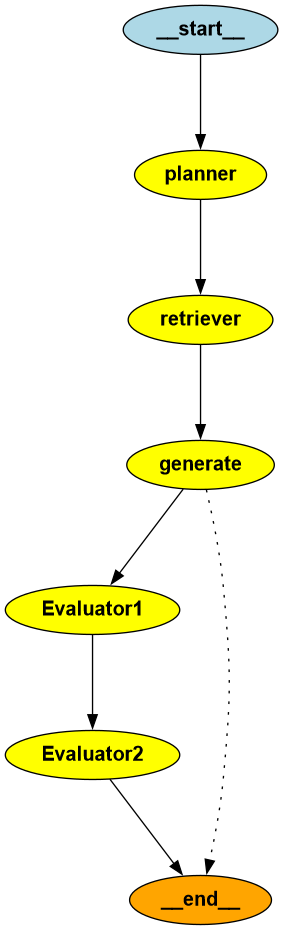

In [261]:
from IPython.display import Image

Image(graph.get_graph().draw_png())


In [262]:
# Simulación del stream y de las salidas
thread = {"configurable": {"thread_id": "1"}}

# Función para generar una salida más bonita
def print_pretty_output():
    initial_state = {
    "task": "Evalua cada uno de los cvs proporcionados. Indica las principales características del evaluado destacando sus fortalezas.",
    "content": []
}

    for s in graph.stream(initial_state, thread):
        display(Markdown(f"### Respuesta del sistema: \n\n{s}"))

# Llamar la función
print_pretty_output()


### Respuesta del sistema: 

{'planner': {'plan': 'Para poder evaluar los CVs proporcionados, necesitaría que me compartas el contenido de los mismos. Una vez que tenga acceso a los textos de los CVs, podré elaborar un esquema de evaluación y resaltar sus características y fortalezas. Por favor, proporciona los documentos o el texto correspondiente.'}}

[Document(id='CV_32', metadata={'filename': 'cvFS.pdf'}, page_content='tenders.'), Document(id='CV_7', metadata={'creationdate': '', 'creator': 'PyPDF', 'page': 0.0, 'page_label': '1', 'producer': 'Skia/PDF m110 Google Docs Renderer', 'source': 'D:\\Documents\\IA\\NLPII\\_Ejercicios_\\docs\\cvFS.pdf', 'title': 'cvFS_VE', 'total_pages': 2.0}, page_content='.'), Document(id='CV_25', metadata={'filename': 'cvFS.pdf'}, page_content='●\nScholarship holder - National Scientific and Technical Research Council (CONICET) 2012-2014')]


### Respuesta del sistema: 

{'retriever': {'context': [Document(id='CV_32', metadata={'filename': 'cvFS.pdf'}, page_content='tenders.'), Document(id='CV_7', metadata={'creationdate': '', 'creator': 'PyPDF', 'page': 0.0, 'page_label': '1', 'producer': 'Skia/PDF m110 Google Docs Renderer', 'source': 'D:\\Documents\\IA\\NLPII\\_Ejercicios_\\docs\\cvFS.pdf', 'title': 'cvFS_VE', 'total_pages': 2.0}, page_content='.'), Document(id='CV_25', metadata={'filename': 'cvFS.pdf'}, page_content='●\nScholarship holder - National Scientific and Technical Research Council (CONICET) 2012-2014')]}}

Context docs: [Document(id='CV_32', metadata={'filename': 'cvFS.pdf'}, page_content='tenders.'), Document(id='CV_7', metadata={'creationdate': '', 'creator': 'PyPDF', 'page': 0.0, 'page_label': '1', 'producer': 'Skia/PDF m110 Google Docs Renderer', 'source': 'D:\\Documents\\IA\\NLPII\\_Ejercicios_\\docs\\cvFS.pdf', 'title': 'cvFS_VE', 'total_pages': 2.0}, page_content='.'), Document(id='CV_25', metadata={'filename': 'cvFS.pdf'}, page_content='●\nScholarship holder - National Scientific and Technical Research Council (CONICET) 2012-2014')]
Content chunks: []


### Respuesta del sistema: 

{'generate': {'answer': 'Para evaluar los CVs proporcionados, es importante considerar las experiencias, habilidades y logros de cada candidato. A continuación, se presentan las principales características y fortalezas de un evaluado en particular, basado en el contexto proporcionado:\n\n**Evaluado: Beca CONICET (2012-2014)**\n\n**Fortalezas:**\n\n1. **Formación Académica Sólida**: La obtención de una beca del Consejo Nacional de Investigaciones Científicas y Técnicas (CONICET) indica un alto nivel de competencia académica y un compromiso con la investigación científica.\n\n2. **Experiencia en Investigación**: La beca sugiere que el evaluado ha estado involucrado en proyectos de investigación, lo que implica habilidades en la formulación de hipótesis, diseño experimental y análisis de datos.\n\n3. **Capacidad de Trabajo Independiente**: La naturaleza de las becas de investigación a menudo requiere que los candidatos trabajen de manera autónoma, lo que demuestra habilidades de autogestión y responsabilidad.\n\n4. **Contribución al Conocimiento Científico**: Al ser parte de un programa de investigación, es probable que el evaluado haya contribuido a publicaciones científicas, lo que resalta su capacidad para comunicar resultados y colaborar con otros investigadores.\n\n5. **Desarrollo de Habilidades Técnicas**: La experiencia en un entorno de investigación puede haber proporcionado al evaluado habilidades técnicas específicas relacionadas con su campo de estudio, así como el uso de herramientas y tecnologías relevantes.\n\n6. **Red de Contactos Profesionales**: Ser parte de una institución reconocida como CONICET puede haber permitido al evaluado establecer conexiones valiosas en el ámbito académico y científico.\n\nEn resumen, el evaluado presenta un perfil fuerte en investigación, con una sólida formación académica y habilidades que son altamente valoradas en el ámbito científico.'}}

Queries: queries=["What are Fabian's main skills?", 'What relevant work experience does Fabian have?', 'What strengths does Fabian demonstrate in his resume?', 'What certifications or qualifications does Fabian possess?', "How does Fabian's experience align with the job requirements?"]
Answer: Fabian's main skills include critical thinking, high analytic capacity, and a passion for the Internet of Things and Embedded Systems. He is also skilled in Embedded C++, freeRTOS, Kicad, SQL Server, AngularJS, NodeJS, and GitHub. Additionally, he has professional proficiency in English and is a native Spanish speaker.
Answer: Fabian Sarmiento has relevant work experience from his time at the Jorge A. Sabato Institute, where he pursued a Master in Sciences and Technology Materials from 2010 to 2012. Additionally, he holds a Bachelor's degree in Electromechanical Engineering from Francisco de Paula Santander University, which he completed between 2001 and 2007. However, specific details about his 

### Respuesta del sistema: 

{'Evaluator1': {'content': ["Fabian's main skills include critical thinking, high analytic capacity, and a passion for the Internet of Things and Embedded Systems. He is also skilled in Embedded C++, freeRTOS, Kicad, SQL Server, AngularJS, NodeJS, and GitHub. Additionally, he has professional proficiency in English and is a native Spanish speaker.", "Fabian Sarmiento has relevant work experience from his time at the Jorge A. Sabato Institute, where he pursued a Master in Sciences and Technology Materials from 2010 to 2012. Additionally, he holds a Bachelor's degree in Electromechanical Engineering from Francisco de Paula Santander University, which he completed between 2001 and 2007. However, specific details about his work experience beyond his education are not provided.", "Fabian demonstrates several strengths in his resume, including:\n\n1. **Educational Background**: He has a solid educational foundation with a Bachelor's degree in Electromechanical Engineering and a Master's degree in Sciences and Technology Materials.\n\n2. **Professional Skills**: He possesses a range of technical skills, including proficiency in Embedded C++, freeRTOS, Kicad, SQL Server, AngularJS, NodeJS, and GitHub, which are relevant to IoT and embedded systems.\n\n3. **Language Proficiency**: He is a native Spanish speaker and has professional proficiency in English, which can be beneficial in diverse work environments.\n\n4. **Analytical and Critical Thinking**: He highlights his critical thinking and high analytical capacity, which are essential for problem-solving in engineering.\n\n5. **Passion for Technology**: His passion for the Internet of Things and Embedded Systems indicates a strong interest in his field, which can drive motivation and innovation.\n\n6. **Team Orientation**: He expresses a desire to be part of team efforts, suggesting good collaboration skills.\n\n7. **Continuous Learning**: His enjoyment of learning and facing new challenges indicates a commitment to personal and professional growth. \n\nOverall, these strengths suggest that Fabian is a well-rounded candidate with both technical expertise and soft skills.", "Fabian Sarmiento possesses the following qualifications and certifications:\n\n1. Master in Sciences and Technology Materials from Jorge A. Sabato Institute - UNSAM (2010-2012).\n2. Bachelor's degree in Electromechanical Engineering from Francisco de Paula Santander University (2001-2007).\n3. Certification in Electric Cars (eCARS03x) with Credential ID: 0946a7a31c0d40aa99dda6a78ef18464.", "I don't know."]}}

✅ Queries: queries=["What are Milena's key technical skills?", 'What job roles has Milena previously held?', 'Does Milena have experience in data analysis?', 'What certifications does Milena have?', 'What industries has Milena worked in?']
Answer: I don't know.
Answer: I don't know.
Answer: I don't know.
Answer: I don't know.
Answer: Milena has worked in the railway industry, specifically with Alstom in the manufacturing of railway coaches for the Metro de Lima. She has also been involved in research related to semiconductors, indicating experience in the electronics or materials science industry.


### Respuesta del sistema: 

{'Evaluator2': {'content': ["I don't know.", "I don't know.", "I don't know.", "I don't know.", 'Milena has worked in the railway industry, specifically with Alstom in the manufacturing of railway coaches for the Metro de Lima. She has also been involved in research related to semiconductors, indicating experience in the electronics or materials science industry.']}}